In [1]:
# ==========================================
# 1. MOUNT DRIVE & IMPORTS
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Install split-folders for easy dataset splitting
!pip install split-folders
import splitfolders

print("✅ Environment ready.")

Mounted at /content/drive
✅ Environment ready.


In [4]:
# ==========================================
# 2. UNZIP & CORRECTED DATA SPLITTING
# ==========================================
import os
import shutil
import zipfile
try:
    import splitfolders
except:
    !pip install split-folders
    import splitfolders

zip_path = '/content/drive/MyDrive/Dataset.zip'
extract_path = '/content/betel_raw'
source_folder = '/content/betel_raw/Dataset' # Points to folder containing variety folders
output_folder = '/content/betel_final'

# 1. Extraction
if os.path.exists(zip_path):
    if os.path.exists(extract_path): shutil.rmtree(extract_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Extraction complete.")
else:
    print("❌ Dataset.zip not found! Check your Google Drive path.")

# 2. Splitting (70% Train, 15% Val, 15% Test)
if os.path.exists(output_folder): shutil.rmtree(output_folder)
splitfolders.ratio(source_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

print("\n✅ Splitting successful!")
print("Classes detected:", os.listdir(os.path.join(output_folder, 'train')))

✅ Extraction complete.


Copying files: 1868 files [00:08, 214.05 files/s]


✅ Splitting successful!
Classes detected: ['Galdalu', 'Mahaneru']


In [5]:
# ==========================================
# 3. DATA PREPROCESSING & AUGMENTATION
# ==========================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training with heavy augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation and Test (only rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/betel_final/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/betel_final/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/betel_final/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"✅ Mapping: {train_generator.class_indices}")

Found 1307 images belonging to 2 classes.
Found 279 images belonging to 2 classes.
Found 282 images belonging to 2 classes.
✅ Mapping: {'Galdalu': 0, 'Mahaneru': 1}


In [6]:
# ==========================================
# 4. HYPERPARAMETER TUNING
# ==========================================
try:
    import keras_tuner as kt
except:
    !pip install keras-tuner
    import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers

def build_model(hp):
    model = models.Sequential()

    # 1st Conv Block
    model.add(layers.Conv2D(hp.Int('conv_1', 32, 64, step=32), (3,3), activation='relu', input_shape=(224,224,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2,2))

    # 2nd Conv Block
    model.add(layers.Conv2D(hp.Int('conv_2', 64, 128, step=64), (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2,2))

    # 3rd Conv Block
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuning_dir',
    project_name='betel_variety'
)

tuner.search(train_generator, epochs=5, validation_data=val_generator)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"✅ Best parameters found. Learning rate: {best_hps.get('learning_rate')}")

Trial 5 Complete [00h 10m 24s]
val_accuracy: 0.8960573673248291

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 52m 48s
✅ Best parameters found. Learning rate: 0.001


In [7]:
# ==========================================
# 5. MODEL TRAINING & CALLBACKS
# ==========================================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build final model
model = tuner.hypermodel.build(best_hps)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_betel_variety_model.h5', monitor='val_accuracy', save_best_only=True)

print("🚀 Starting final training...")
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

🚀 Starting final training...
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9276 - loss: 3.1048

41/41 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9288 - loss: 3.0800 - val_accuracy: 0.8674 - val_loss: 92.7412
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9988 - loss: 0.2196 - val_accuracy: 0.8674 - val_loss: 16.4292
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9934 - loss: 1.2847

41/41 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9934 - loss: 1.2804 - val_accuracy: 0.9606 - val_loss: 4.5742
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9999 - loss: 0.0023

41/41 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 0.9892 - val_loss: 0.1985
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9988 - loss: 0.1769

41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9988 - loss: 0.1838 - val_accuracy: 0.9964 - val_loss: 0.1068
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.9928 - loss: 1.1494 - val_accuracy: 0.9821 - val_loss: 0.3445
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9991 - loss: 0.1986

41/41 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9991 - loss: 0.1978 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9988 - loss: 0.2715 - val_accuracy: 0.7133 - val_loss: 49.8626
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9966 - loss: 1.2442 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 1.0000 - loss: 2.1932e-19 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 1.0000 - loss: 5.5379e-42 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.9993 - loss: 0.0675 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 13/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 14/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 1.0000 - loss: 0.

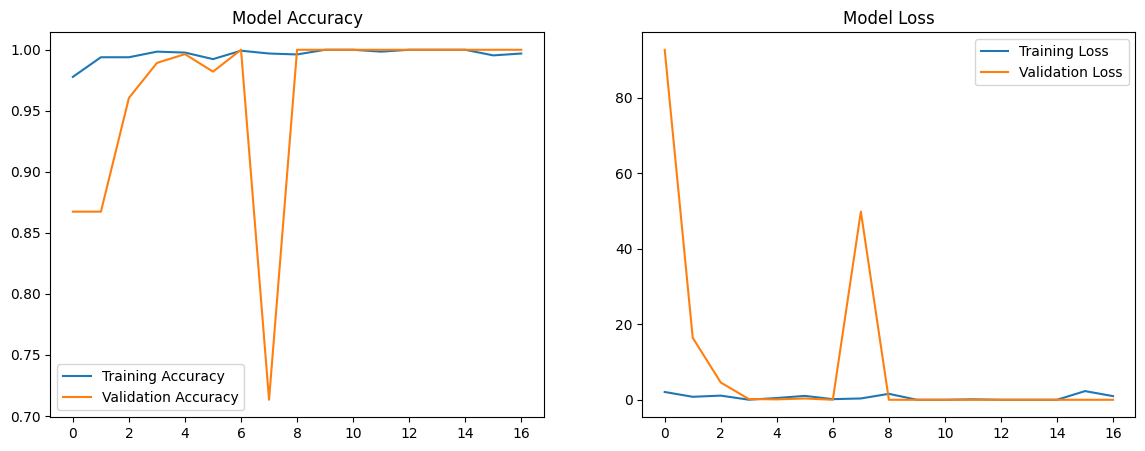


🧪 Evaluating on Test Set...
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
🎯 Final Test Accuracy: 100.00%
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


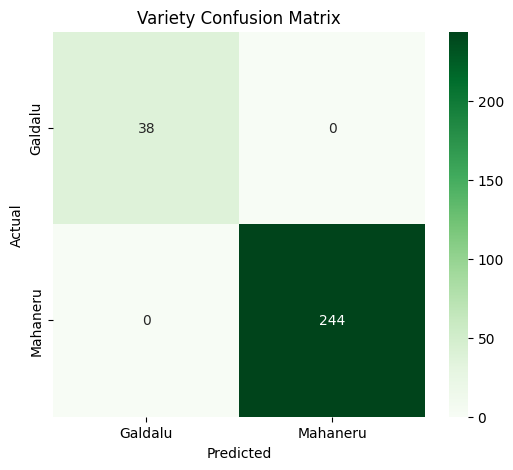


📋 Classification Report:
              precision    recall  f1-score   support

     Galdalu       1.00      1.00      1.00        38
    Mahaneru       1.00      1.00      1.00       244

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



In [8]:
# ==========================================
# 6. RESULTS & VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# Final Test Set Evaluation
print("\n🧪 Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"🎯 Final Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Variety Confusion Matrix')
plt.show()

print("\n📋 Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))